# Statistics and Data Journalism
## HODP Bootcamp Week 5
### October 15, 2019

### Goals for this week:
* Learn what a significance test and confidence interval are
* Practice basic linear regression
* Understand the difference between correlation and causation

### Parameters vs. Statistics
* In data journalism, we're often interested in estimating *pararameters* of interest, which are fixed but unknown quantities
* We estimate these with *sample statistics*, which are known but random quantities
* Seems very simple but mixing up the two is a common pitfall in journalism

### Load in the data
Here is a dataset of US House election data in 2018. I've taken the liberty of cleaning the data for you using R. The original dataset is from MIT election labs and is also included as is my cleaning code. 

In [85]:
import pandas as pd
import numpy as np

house = pd.read_csv("house_elections_2018_clean.csv")
house.head()

,Unnamed: 0,year,state,electiondistrict,runoff,special,candidate,party,writein,candidatevotes,totalvotes,prop
0,28278,2018,Alabama,AL1,NaN,False,Robert Kennedy Jr.,democrat,False,89226,242617,0.367765
1,28279,2018,Alabama,AL1,NaN,False,Bradley Byrne,republican,False,153228,242617,0.631563
2,28281,2018,Alabama,AL2,NaN,False,Martha Roby,republican,False,138879,226230,0.613884
3,28282,2018,Alabama,AL2,NaN,False,Tabitha Isner,democrat,False,86931,226230,0.384259
4,28284,2018,Alabama,AL3,NaN,False,Mike Rogers,republican,False,147770,231915,0.637173


## Hypothesis Tests and P-Values
### Did Rebublicans and Democrats win significantly different proportions of the vote in 2018 elections? 
#### Two sample t-tests
We're going to conduct a two sample t-test. We can do this with SciPy's built in t-test function. A two sample t-test is a test of how "far" two sample statistics are from each other; we're usually trying to see if they are significantly different from each other. Let's use Python to see if the proportions of votes for Dems and Repubs are significantly different.

This testing paradigm assumes that our observations are normally distributed. Let's also plot a histogram of our observations to make sure this assumption is satisfied 

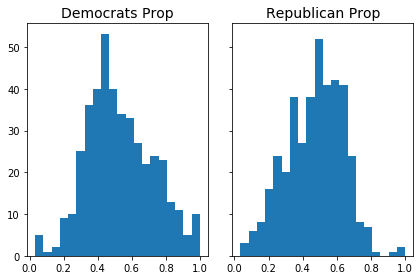

In [86]:
import matplotlib
import matplotlib.pyplot as plt

democrats = house[house.party == 'democrat']
republicans = house[house.party == 'republican']
n_bins = 20
fig, ax = plt.subplots(1, 2, sharey=True, tight_layout=True)
ax[0].hist(democrats.prop, bins=n_bins)
ax[0].set_title("Democrats Prop", fontsize=14)
ax[1].hist(republicans.prop, bins=n_bins)
ax[1].set_title("Republican Prop", fontsize=14)

plt.show()

Now that we've checked our assumption of normality, we can perform our t-test.

In [87]:
from scipy import stats
stats.ttest_ind(democrats.prop, republicans.prop, equal_var = False)


Ttest_indResult(statistic=4.474054464422503, pvalue=8.770242865379696e-06)

### Permutation Tests
If our assumption of normality had failed, we would probably be better off performing some sort of nonparametric test. One such test is a permutation test. A permutation works by assuming that the labels of democrat and republican make no difference in determining proportions. Therefore, shuffling up the labels should not affect averages between the two groups. 

The test works by shuffling labels and computing differences in means many times. This produces a distribution of test statistics. Then, we calculate a p-value by finding the probability of observing a test statistic as extreme or more extreme than the one produced by our particular permutation of labels and proportions. 

This test does not assume normality, but it does assume that the two groups are drawn from the same distribution. This assumption needs to be checked as well. We will check it by using boxplots. 

Code to do this is given below. 

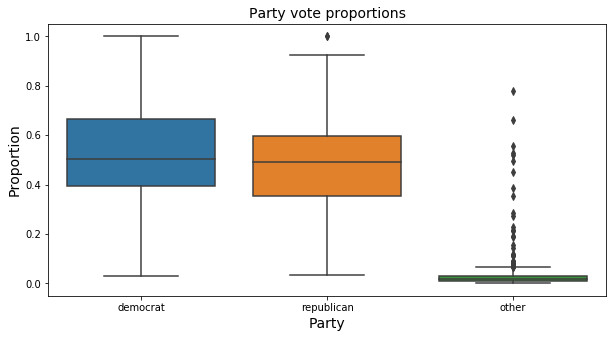

0.0

In [89]:
from mlxtend.evaluate import permutation_test
import seaborn as sns

f, ax = plt.subplots(1,1, figsize=(10, 5))
sns.boxplot(x='party', y='prop', data=house)
ax.set_xlabel("Party", fontsize=14)
ax.set_ylabel("Proportion", fontsize=14)
ax.set_title("Party vote proportions", fontsize=14)
plt.show()

p_value = permutation_test(democrats.prop, republicans.prop,
                           method='approximate',
                           num_rounds=10000,
                           seed=0)

p_value


### Interpreting the Results
Now, we have a p-value. The p-value is often misunderstood or improperly interpreted, so it's very important to know what it actually means. **A p-value is the probability of observing our data, given that the null hypothesis is correct.** So, we assume that our data are random, but the true values are fixed. A common pitfall when interpreting p-values is to think of the p-value as the probability of the null hypothesis being correct, but this interpretation is wrong. Looking at the results above with this in mind, we can see that if Democrats and Republicans truly had the same average ranking, there would be very low probability of getting the data we got (though still possible), so we can pretty reasonably reject the null hypothesis and say that the two parties do not have equal proportions. Because the test statistic is negative, we can see that Adams has a lower (better) ranking. 

In general, a common rule of thumb is to reject the null hypothesis when the p-value is less than 0.05. When we fail to reject the null hypothesis, we should never say that we "accept" or "prove" the null. All we have done is failed to reject it; we can never prove the null hypothesis true.

### One-sample tests

We can also do one-sample tests, where we compare our statistic to a set value. A one sample t-test is a test of how "far" a sample statistic is from a hypothesized "true" value, still assuming normality of observations. For example, if Dean Khurana tells you that he believes 75% of students support the social group sanctions, but your HODP survey suggests that only 65% of students support the sanctions, you can test whether that difference is sufficiently large to dispute Khurana's claim.

To run such a test, you can use the stats.ttest_1samp() command (documentation here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html)

**Let's say Fox News claims that the true proportion of American that voted for Republicans in 2018 was 49%. Perform a one sample t-test to validate this claim. Comment on your assumptions for a one sample t-test.**

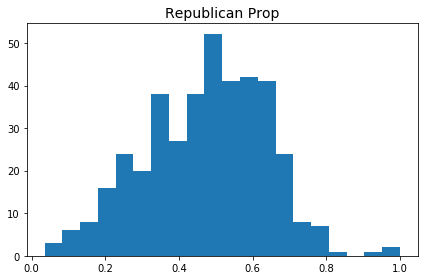

Ttest_1sampResult(statistic=-1.879688695739978, pvalue=0.060880814638531705)

In [90]:
fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)
ax.hist(republicans.prop, bins=n_bins)
ax.set_title("Republican Prop", fontsize=14)
plt.show()

stats.ttest_1samp(republicans.prop, 0.49)

Equally important in data journalism: add an interpretation of your data analysis here! 
**TODO **

With a pvalue of 0.06, we do not have evidence that the Republican proportion was different from 49%. 

## Confidence Intervals
You're probably quite familiar with point estimates in Statistics, where we say the observed proportion of democratic votes is, say, 0.53. A confidence interval is, as the name suggests, an interval that we think the true value is likely to fall in. These intervals have a certain level of *confidence*, or the percentage of intervals calculated using this method that contain the true value. There is a trade off between confidence and width - higher confidence is great, but it will also widen the interval, which can make it less useful. For example, you can construct a 100% confidence interval for anything, but it goes from negative infinity to positive infinity, and tells us nothing about the parameter of interest.

In practice, 95% confidence intervals are quite popular, which means that, on average, 19 out of every 20 contain the true value of the parameter of interest. A common pitfall with confidence intervals is to say there is a 95% chance that the true value falls inside the interval, but this interpretation is incorrect, so please stay away from this phrase in your articles.

Now, let's construct a 95% confidence interval for the proportion of democratic votes. We have to do a bit more work to generate a confidence interval in Python. We need to provide SciPy's interval function with a confidence level, a center (the sample mean), and a scale (the standard error, which is the sample standard deviation divided by the square root of one less than the length of the dataset).

In [91]:
mean, sigma = np.mean(democrats.prop), np.std(democrats.prop)

conf_int = stats.norm.interval(0.95, 
                               loc = mean, 
                               scale = sigma/np.sqrt(len(democrats.prop) - 1))
conf_int

(0.5121324337735289, 0.5491756352238242)

Now, try generating an interval for the republican data using a different confidence level, and interpret your results.

In [7]:
#generate the interval here

Interpret your results here!

## Causation vs. Correlation
You've all probably heard this before, but it's important to hear it again: correlation does not imply causation. It's pretty rare that we'll be able to show causation in a HODP article, so it's important to frame most of our work as a correlation or trend we noticed, rather than as a direct cause. Often, though, it will intuitively make sense that there "should" or at least "could" be a causal connection. In those cases, make sure to frame your writing as a "possible explanation" than as a statement of what is going on. For example, the percentage of female concentrators by department is likely strongly correlated with the percentage of female faculty members, and there is probably some causal effect here. However, it's best to cite other research on whether such a trend has a causal effect, or to cite relevant quantitative work. For example, in an article about gender balance in different departments, we could talk about existing research on the effect of faculty gender on students and potentially cite relevant Crimson articles, but we should not conclude that (for example) low female faculty presence in Mathematics *causes* low female student presence in Mathematics.

For people who are particularly interested in causation, talk to Seth or look at Stat 111 (Statistical Inference), Stat 186 (Causal Inference), and Ec 1123 (Econometrics).

Let's look at some examples of how we might be able to find correlations that are likely not causal. This will also show you how to find a correlation coefficient. If all you want is the correlation, it's very easy.

In [92]:
from scipy.stats.stats import pearsonr

rankings = pd.read_csv("house_rankings_2018.csv")
houses = rankings.House
rankings.set_index("House", inplace = True)
rankings
#monthly high temps in Boston
bostontemps = [37, 39, 46, 57, 67, 77, 82, 81, 73, 62, 52, 42]
levCounts = list(rankings.values[5,])
pearsonr(levCounts, bostontemps)

(0.7635806435842531, 0.0038495884100404063)

## Basic Regression
Regression is a very useful tool for prediction. Linear regressions allow us to easily model a linear relationship between a response/dependent/Y variable and 1 or more predictor/independent/X variables. This is a very widely used technique, so if you plan to use regression in your project, please come talk to us for a more in depth treatment of the subject, but here are the basics! Regressions in Python are fairly easy to do: we just need a Y list, and at least one X list of equal length! Below, we've built a regression based on the same Leverett and temperature data from above. Note that you may sometimes need to reshape data a bit.

[37, 39, 46, 57, 67, 77, 82, 81, 73, 62, 52, 42]
[[37]
 [39]
 [46]
 [57]
 [67]
 [77]
 [82]
 [81]
 [73]
 [62]
 [52]
 [42]]


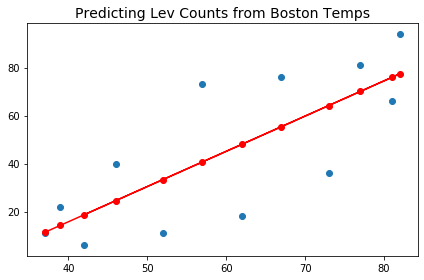

In [93]:
from sklearn import linear_model
import statsmodels.api as sm
lm = linear_model.LinearRegression()
print(bostontemps)
bostontemps = np.array(bostontemps).reshape(-1, 1)
print(bostontemps)
#X, Y is the order
reg = lm.fit(bostontemps, levCounts)
beta0, beta1 = reg.intercept_, reg.coef_
y_predict = np.multiply(bostontemps,beta1) + beta0

fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)
ax.scatter(bostontemps, levCounts)
plt.plot(bostontemps, y_predict, '-o',color='r')
ax.set_title("Predicting Lev Counts from Boston Temps", fontsize=14)
plt.show()

## Multiple Regression

We can also run a regression model with more than one predictor variables. All you have to do is add the predictors to your design matrix X and use the lm.fit() command.

On your own, try fitting a model to predict number of first-choice votes each house received, with at least two predictor variables. I've given you two possible variables below, though you're welcome to find more, or different ones. Again, note that you may need to reshape data.

*Hint: You still need to find the dependent variable, and structure it like the `levCounts` variable above.*

In [96]:
#walking time from Widener Library (in minutes), from Google Maps
dist = [2, 15, 7, 8, 3, 5, 7, 16, 7, 2, 17, 6]
#was the house renovated in last 10 years? 1 if true
renovated = [0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1]

X = np.matrix([dist, renovated]).transpose()
Y = [rankings.values[i,0] for i in range(0, 12)]
Y = np.array([Y]).reshape(-1, 1)

reg = lm.fit(X, Y)
[reg.intercept_, reg.coef_]


[array([31.89518947]), array([[-1.40647675, 56.9746036 ]])]

### Prediction
Finally, one of the most useful things we can do with a predictive model is make predictions! Assuming you called your model `reg`, use the command below to predict the number of first choice votes for Adams House after the renovations begin.

In [82]:
reg.predict(np.array([[2, 1]]))

array([[86.05683956]])